# Test Setup for Transient Analysis

In [1]:
from CircuitCalculator.Circuit.solution import DCSolution
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from CircuitCalculator.Network import elements as elm
from CircuitCalculator.Network.network import Network, Branch

In [2]:
# G1, G2, G3 = 10, 20, 30
# R1, R2, R3 = 1/G1, 1/G2, 1/G3
R1, R2, R3 = 10, 20, 30
G1, G2, G3 = 1/R1, 1/R2, 1/R3
RC = 40e6
C = 1e-3
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=1, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.capacitor(id='C', C=C, nodes=('2', '3')),
    cmp.resistor(id='R3', R=R3, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])
solution = DCSolution(circuit)

## Funktion zur Berechnung der State Space Matrizen

In [3]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
from CircuitCalculator.Network.NodalAnalysis import labelmapper as map
from CircuitCalculator.Circuit.circuit import Component
def voltage_derivatives(components: list[Component]) -> list[Component]:
    return [c for c in components if c.type == 'capacitor']

def create_state_space_matrices_from_circuit(circuit: Circuit, node_index_mapper: map.NodeIndexMapper = map.default) -> tuple[np.ndarray, np.ndarray]:
    network = transform_circuit(circuit, w=0)
    node_mapping = node_index_mapper(network)
    Y = create_node_matrix_from_network(network).real
    Q = create_source_incidence_matrix_from_network(network=network).real
    all_Cs = voltage_derivatives(circuit.components)
    Delta = np.zeros((len(all_Cs), Y.shape[1]))
    for k in range(len(all_Cs)):
        for i_label, i in node_mapping.items():
            if i_label in all_Cs[k].nodes:
                if i_label == all_Cs[k].nodes[0]:
                    Delta[k][i] = +1
                else:
                    Delta[k][i] = -1
    Delta = np.matrix(Delta)
    invC = np.array([-1/float(C.value['C']) for C in all_Cs])
    A = np.linalg.inv(Delta*np.linalg.inv(Y)*Delta.T)*np.diag(invC)
    B = -A*Delta*np.linalg.inv(Y)*Q
    return A, B

In [4]:
A, B = create_state_space_matrices_from_circuit(circuit=circuit)
print(A), print(B)

[[-27.27272727]]
[[18.18181818]]


(None, None)

In [5]:
from scipy import signal

sys = signal.StateSpace(A, B, 1, 0)


In [6]:
t = np.arange(0, 0.5, 0.0003)
U = t > 0.1

tout, yout, xout = signal.lsim(sys, U, t)

In [7]:
def pll(R1, R2):
    return R1*R2/(R1+R2)

Ri = pll(pll(R1, R2)+R3, RC)
tau = Ri*C
u_ref = U*RC/(RC+R3)*pll(R2, R3+RC)/(R1+pll(R2, R3+RC))*(1-np.exp(-(tout-0.1)/tau))

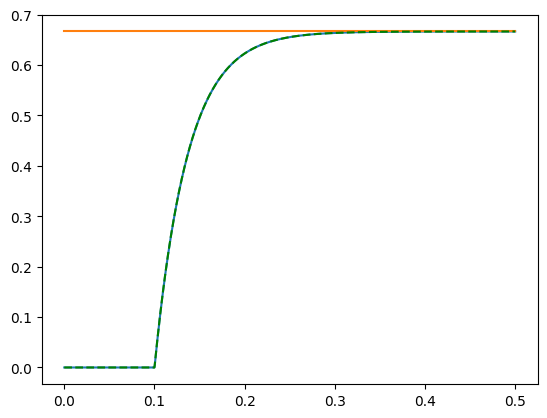

In [8]:
import matplotlib.pyplot as plt

plt.plot(tout, yout)
plt.plot((tout[0], tout[-1]), (solution.get_voltage('C'), solution.get_voltage('C')))
plt.plot(tout, u_ref, 'g--')
